# import 

In [1]:
import os
import sys 

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

import torch
from torch import nn 
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score


from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.tab_model import TabNetRegressor
from pytorch_tabnet.tab_model import TabNetClassifier

import lightgbm as lgb

from utils.util import seed_everything

In [2]:
INPUT_PATH = '/working/input/titanic'
OUTPUT_PATH = '/working/output'

train = pd.read_csv(os.path.join(INPUT_PATH,'train.csv'))
test = pd.read_csv(os.path.join(INPUT_PATH,'test.csv'))


In [3]:
seed_everything(seed_value=42)

/opt/conda/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


# Preprocess

In [4]:
n_train = len(train)
data = pd.concat([train,test],sort=False).reset_index(drop=True)

In [5]:
data['Sex']=data['Sex'].replace(['male','female'],[0,1])
data['Embarked'] =  data['Embarked'].fillna(('S'))
data['Embarked'] =  data['Embarked'].map({'S':0,'C':1,'Q':2}).astype(int)
data['Fare'] = data['Fare'].fillna(np.mean(data['Fare']))
data['Age'] = data['Age'].fillna(data['Age'].median())

In [6]:
del_col = ['Name','PassengerId','Ticket','Cabin']
data.drop(del_col, axis=1, inplace=True)

In [7]:
train = data[:n_train].reset_index(drop=True)
test = data[n_train:].reset_index(drop=True)

# Feature cols

In [8]:
feature_col = [col for col in train.columns.tolist() if col != 'Survived']

Define categorical features for categorical embeddings 

In [9]:
feature_col

['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

In [10]:
cate_cols = ['Pclass','Sex','SibSp','Parch','Embarked']

cate_dims = {}

for col in cate_cols:
    cate_dims[col] = train[col].unique()

In [11]:
cat_idxs = [i for i, f in enumerate(feature_col) if f in cate_cols]
cat_dims = [cate_dims[f] for i, f in enumerate(feature_col) if f in cate_cols]

# TabNet Pretraining

In [12]:
tabnet_params = dict(n_d=8, n_a=8, n_steps=3, gamma=1.3,
                     n_independent=2, n_shared=2,
                     seed=42, lambda_sparse=1e-3, 
                     optimizer_fn=torch.optim.Adam, 
                     optimizer_params=dict(lr=2e-2),
                     mask_type="entmax",
                     scheduler_params=dict(mode="min",
                                           patience=5,
                                           min_lr=1e-5,
                                           factor=0.9,),
                     scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
                     verbose=10
                    )

In [13]:
pretrainer = TabNetPretrainer(**tabnet_params)

pretrainer.fit(
        X_train=train.drop('Survived',axis=1).values,
        eval_set=[train.drop('Survived',axis=1).values],
        max_epochs=200,
        patience=20,
        batch_size=256,
        virtual_batch_size=128,
        num_workers=1,
        drop_last=True
)

Device used : cpu
epoch 0  | loss: 4.22455 | val_0_unsup_loss: 20.43877|  0:00:00s
epoch 10 | loss: 1.69857 | val_0_unsup_loss: 2.50951 |  0:00:04s
epoch 20 | loss: 1.21721 | val_0_unsup_loss: 1.44622 |  0:00:08s
epoch 30 | loss: 0.81575 | val_0_unsup_loss: 1.23545 |  0:00:12s
epoch 40 | loss: 0.92009 | val_0_unsup_loss: 1.19396 |  0:00:16s
epoch 50 | loss: 0.85539 | val_0_unsup_loss: 1.11022 |  0:00:21s
epoch 60 | loss: 0.8575  | val_0_unsup_loss: 1.0535  |  0:00:25s
epoch 70 | loss: 0.87378 | val_0_unsup_loss: 1.02438 |  0:00:29s
epoch 80 | loss: 0.93344 | val_0_unsup_loss: 1.0308  |  0:00:34s
epoch 90 | loss: 0.84047 | val_0_unsup_loss: 0.97811 |  0:00:38s
epoch 100| loss: 0.89844 | val_0_unsup_loss: 0.94757 |  0:00:43s
epoch 110| loss: 0.75359 | val_0_unsup_loss: 0.93703 |  0:00:47s
epoch 120| loss: 0.77009 | val_0_unsup_loss: 0.93611 |  0:00:52s

Early stopping occured at epoch 126 with best_epoch = 106 and best_val_0_unsup_loss = 0.90037
Best weights from best epoch are automatic

# Make Folds

In [14]:
skf = StratifiedKFold(n_splits=5)
for i, (trn_idx, val_idx) in enumerate(skf.split(train.drop('Survived',axis=1), train['Survived'])):
    train.loc[val_idx,'fold'] = int(i)

# Tabnet Training

In [15]:

oof = np.zeros((len(train),))
test_preds_all = np.zeros((len(test),))
models = []

for fold_num in range(5):
    trn_idx = train[train.fold != fold_num].index
    val_idx = train[train.fold == fold_num].index
    print(f"FOLD: {fold_num}")
    
    X_train, y_train = train[feature_col].values[trn_idx],  train['Survived'].values[trn_idx]
    X_valid, y_valid = train[feature_col].values[val_idx], train['Survived'].values[val_idx]
    
    tabnet_params = dict(n_d=8, n_a=8, n_steps=3, gamma=1.3,
                     n_independent=2, n_shared=2,
                     seed=42, lambda_sparse=1e-3,
                     optimizer_fn=torch.optim.Adam,
                     optimizer_params=dict(lr=2e-2,
                                           weight_decay=1e-5
                                          ),
                     mask_type="entmax",
                     scheduler_params=dict(max_lr=0.05,
                                           steps_per_epoch=int(X_train.shape[0] / 256),
                                           epochs=200,
                                           is_batch_level=True
                                          ),
                     scheduler_fn=torch.optim.lr_scheduler.OneCycleLR,
                     verbose=10,
                     cat_idxs=cat_idxs, # comment out when Unsupervised
                     cat_dims=cat_dims, # comment out when Unsupervised
                     cat_emb_dim=1 # comment out when Unsupervised
                    )
    model = TabNetClassifier(**tabnet_params)
    model.fit(X_train=X_train,
              y_train=y_train,
              eval_set=[(X_valid, y_valid)],
              eval_name = ["valid"],
              eval_metric = ["auc"],
              max_epochs=200,
              patience=20, batch_size=256, virtual_batch_size=128,
              num_workers=0, drop_last=False,
              from_unsupervised=pretrainer # comment out when Unsupervised
             )
    
    oof[val_idx] = model.predict(X_valid)
    models.append(model)
    pred_test = model.predict(test[feature_col].values)
    test_preds_all += pred_test / 5



FOLD: 0
Device used : cpu
Loading weights from unsupervised pretraining


/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:96: UserWarning: Pretraining: cat_dims changed from [array([3, 1, 2]), array([0, 1]), array([1, 0, 3, 4, 2, 5, 8]), array([0, 1, 2, 5, 3, 4, 6]), array([0, 1, 2])] to []
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:96: UserWarning: Pretraining: cat_idxs changed from [0, 1, 3, 4, 6] to []
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.85153 | valid_auc: 0.54914 |  0:00:00s
epoch 10 | loss: 0.58294 | valid_auc: 0.59321 |  0:00:01s
epoch 20 | loss: 0.42628 | valid_auc: 0.78202 |  0:00:02s
epoch 30 | loss: 0.37901 | valid_auc: 0.8469  |  0:00:03s
epoch 40 | loss: 0.37052 | valid_auc: 0.84704 |  0:00:04s
epoch 50 | loss: 0.39622 | valid_auc: 0.79183 |  0:00:05s
epoch 60 | loss: 0.37375 | valid_auc: 0.8473  |  0:00:06s

Early stopping occured at epoch 63 with best_epoch = 43 and best_valid_auc = 0.86535
Best weights from best epoch are automatically used!
FOLD: 1
Device used : cpu
Loading weights from unsupervised pretraining


/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:96: UserWarning: Pretraining: cat_dims changed from [array([3, 1, 2]), array([0, 1]), array([1, 0, 3, 4, 2, 5, 8]), array([0, 1, 2, 5, 3, 4, 6]), array([0, 1, 2])] to []
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:96: UserWarning: Pretraining: cat_idxs changed from [0, 1, 3, 4, 6] to []
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.8748  | valid_auc: 0.67005 |  0:00:00s
epoch 10 | loss: 0.60845 | valid_auc: 0.71818 |  0:00:01s
epoch 20 | loss: 0.41081 | valid_auc: 0.81444 |  0:00:02s
epoch 30 | loss: 0.361   | valid_auc: 0.79786 |  0:00:03s

Early stopping occured at epoch 39 with best_epoch = 19 and best_valid_auc = 0.82273
Best weights from best epoch are automatically used!
FOLD: 2
Device used : cpu
Loading weights from unsupervised pretraining


/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:96: UserWarning: Pretraining: cat_dims changed from [array([3, 1, 2]), array([0, 1]), array([1, 0, 3, 4, 2, 5, 8]), array([0, 1, 2, 5, 3, 4, 6]), array([0, 1, 2])] to []
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:96: UserWarning: Pretraining: cat_idxs changed from [0, 1, 3, 4, 6] to []
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.84117 | valid_auc: 0.59051 |  0:00:00s
epoch 10 | loss: 0.6066  | valid_auc: 0.74806 |  0:00:01s
epoch 20 | loss: 0.4238  | valid_auc: 0.826   |  0:00:02s
epoch 30 | loss: 0.40128 | valid_auc: 0.81544 |  0:00:03s
epoch 40 | loss: 0.38532 | valid_auc: 0.8377  |  0:00:04s
epoch 50 | loss: 0.37821 | valid_auc: 0.826   |  0:00:04s
epoch 60 | loss: 0.3547  | valid_auc: 0.86745 |  0:00:05s
epoch 70 | loss: 0.34897 | valid_auc: 0.87233 |  0:00:06s
epoch 80 | loss: 0.35658 | valid_auc: 0.85802 |  0:00:07s

Early stopping occured at epoch 82 with best_epoch = 62 and best_valid_auc = 0.88202
Best weights from best epoch are automatically used!
FOLD: 3
Device used : cpu
Loading weights from unsupervised pretraining


/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:96: UserWarning: Pretraining: cat_dims changed from [array([3, 1, 2]), array([0, 1]), array([1, 0, 3, 4, 2, 5, 8]), array([0, 1, 2, 5, 3, 4, 6]), array([0, 1, 2])] to []
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:96: UserWarning: Pretraining: cat_idxs changed from [0, 1, 3, 4, 6] to []
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.85323 | valid_auc: 0.61705 |  0:00:00s
epoch 10 | loss: 0.61379 | valid_auc: 0.74719 |  0:00:01s
epoch 20 | loss: 0.41736 | valid_auc: 0.83656 |  0:00:02s
epoch 30 | loss: 0.38189 | valid_auc: 0.83676 |  0:00:03s
epoch 40 | loss: 0.39883 | valid_auc: 0.80856 |  0:00:04s

Early stopping occured at epoch 45 with best_epoch = 25 and best_valid_auc = 0.89559
Best weights from best epoch are automatically used!
FOLD: 4
Device used : cpu
Loading weights from unsupervised pretraining


/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:96: UserWarning: Pretraining: cat_dims changed from [array([3, 1, 2]), array([0, 1]), array([1, 0, 3, 4, 2, 5, 8]), array([0, 1, 2, 5, 3, 4, 6]), array([0, 1, 2])] to []
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:96: UserWarning: Pretraining: cat_idxs changed from [0, 1, 3, 4, 6] to []
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.86898 | valid_auc: 0.60231 |  0:00:00s
epoch 10 | loss: 0.62353 | valid_auc: 0.76645 |  0:00:01s
epoch 20 | loss: 0.45364 | valid_auc: 0.86757 |  0:00:02s
epoch 30 | loss: 0.39923 | valid_auc: 0.89602 |  0:00:03s
epoch 40 | loss: 0.38689 | valid_auc: 0.88592 |  0:00:04s
epoch 50 | loss: 0.3777  | valid_auc: 0.86451 |  0:00:05s
epoch 60 | loss: 0.38406 | valid_auc: 0.88313 |  0:00:06s

Early stopping occured at epoch 66 with best_epoch = 46 and best_valid_auc = 0.90467
Best weights from best epoch are automatically used!


# Metric

In [16]:
print('ROC-AUC')
print(roc_auc_score(train['Survived'].ravel(), oof.ravel()))
print('Accuracy')
print(accuracy_score(train['Survived'].ravel(), (oof >0.5).astype('int').ravel()))
print('ROC-AUC test')

ROC-AUC
0.781564567155594
Accuracy
0.813692480359147
ROC-AUC test


# Global Explainability: feature importance

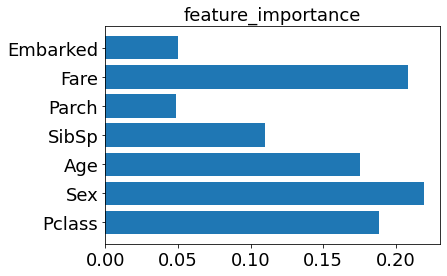

In [17]:
for fold_num, model in enumerate(models):
    # Feature Importance
    feat_imp_fold = pd.DataFrame(model.feature_importances_,index=feature_col, columns= [f'imp_{fold_num}'])
    if fold_num == 0:
        feature_importance = feat_imp_fold.copy()
    else:
        feature_importance = pd.concat([feature_importance, feat_imp_fold], axis=1)
        

feature_importance['imp_mean'] = feature_importance.mean(axis=1)
plt.tick_params(labelsize=18)
plt.barh(feature_importance.index.values,feature_importance['imp_mean']);
plt.title('feature_importance',fontsize=18);

In [18]:
feature_importance

,imp_0,imp_1,imp_2,imp_3,imp_4,imp_mean
Pclass,0.166779,0.205544,0.221500,0.186626,0.160964,0.188283
Sex,0.205414,0.163410,0.250233,0.199747,0.278334,0.219428
Age,0.112469,0.153309,0.218014,0.207240,0.186780,0.175562
SibSp,0.082567,0.097046,0.096862,0.148652,0.125677,0.110161
Parch,0.081826,0.035052,0.052029,0.028617,0.046823,0.048869
Fare,0.204957,0.284996,0.131835,0.219287,0.198966,0.208008
Embarked,0.145988,0.060644,0.029527,0.009831,0.002457,0.049689


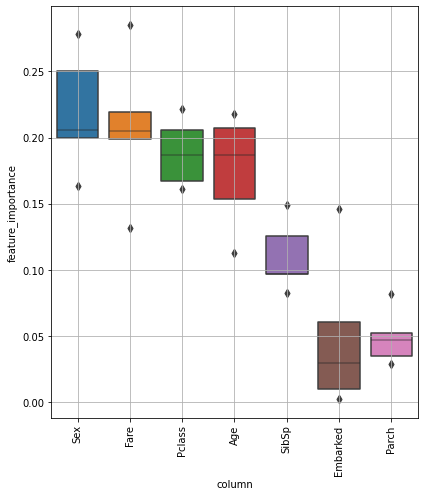

In [19]:
def visualize_importance(models,df):
    feature_importance_df = pd.DataFrame()
    
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = df.columns
        _df['fold'] = i+1
        feature_importance_df = pd.concat([feature_importance_df,_df],axis=0,ignore_index=True)
    
    order = feature_importance_df.groupby('column').sum()[['feature_importance']].sort_values('feature_importance',ascending=False).index
    
    fig, ax = plt.subplots(figsize=(max(6, len(order)*.5),7))
    sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax)
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig,ax

fig, ax = visualize_importance(models,train[feature_col] )

# Local explainability and masks

In [20]:
explain_matrix, masks = model.explain(test[feature_col].values)

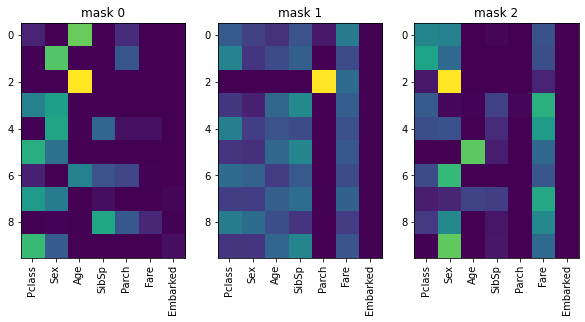

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(10,7))

for i in range(3):
    ax[i].imshow(masks[i][:10])
    ax[i].set_title(f"mask {i}")
    ax[i].set_xticks([i for i in range(len(train[feature_col].columns))])
    ax[i].set_xticklabels(train[feature_col].columns)
    ax[i].tick_params(axis='x', rotation=90)

# LightGBM

In [22]:
# changet to category 

for col in cate_cols:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

In [23]:
oof = np.zeros((len(train),))
test_preds_all = np.zeros((len(test),))
models = []

for fold_num in range(5):
    trn_idx = train[train.fold != fold_num].index
    val_idx = train[train.fold == fold_num].index
    print(f"FOLD: {fold_num}")
    
    X_train, y_train = train[feature_col].values[trn_idx],  train['Survived'].values[trn_idx]
    X_valid, y_valid = train[feature_col].values[val_idx], train['Survived'].values[val_idx]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_valid = lgb.Dataset(X_valid, y_valid)
    
    params = {
        'objective': 'binary',
        'importance_type': 'gain',    
    }
    
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train,y_train,eval_set=[(X_train,y_train)],
              verbose=10)
    
    oof[val_idx] = model.predict(X_valid)
    models.append(model)
    
    test_preds_all += model.predict(test[feature_col]) / 5


FOLD: 0
[10]	training's binary_logloss: 0.415056
[20]	training's binary_logloss: 0.339912
[30]	training's binary_logloss: 0.298753
[40]	training's binary_logloss: 0.265532
[50]	training's binary_logloss: 0.239837
[60]	training's binary_logloss: 0.219283
[70]	training's binary_logloss: 0.202619
[80]	training's binary_logloss: 0.185783
[90]	training's binary_logloss: 0.171218
[100]	training's binary_logloss: 0.160344
FOLD: 1
[10]	training's binary_logloss: 0.412185
[20]	training's binary_logloss: 0.326
[30]	training's binary_logloss: 0.277814
[40]	training's binary_logloss: 0.243692
[50]	training's binary_logloss: 0.217736
[60]	training's binary_logloss: 0.197754
[70]	training's binary_logloss: 0.180134
[80]	training's binary_logloss: 0.166068
[90]	training's binary_logloss: 0.15343
[100]	training's binary_logloss: 0.143583
FOLD: 2
[10]	training's binary_logloss: 0.430307
[20]	training's binary_logloss: 0.351541
[30]	training's binary_logloss: 0.3128
[40]	training's binary_logloss: 0.280

In [24]:
print('ROC-AUC')
print(roc_auc_score(train['Survived'].ravel(), oof.ravel()))
print('Accuracy')
print(accuracy_score(train['Survived'].ravel(), (oof>.5).astype('int').ravel()))

ROC-AUC
0.812889464097402
Accuracy
0.8271604938271605


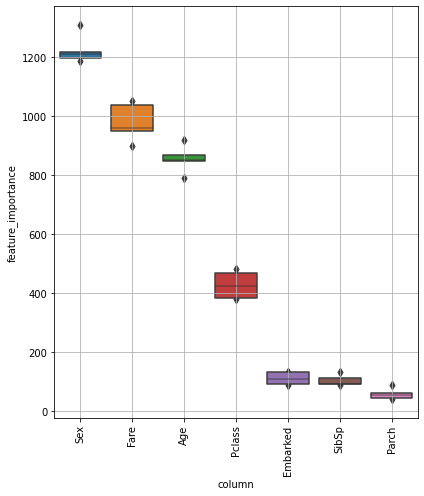

In [25]:
fig, ax = visualize_importance(models,train[feature_col] )

# NN model

In [26]:
target_cols = ['Survived']

In [27]:
class TitanicDataset:
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float),
            'y' : torch.tensor(self.targets[idx], dtype=torch.float)            
        }
        return dct
    
class TestDataset:
    def __init__(self, features):
        self.features = features
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float)
        }
        return dct

In [28]:
def train_fn(model, optimizer, scheduler, loss_fn, dataloader, device):
    model.train()
    final_loss = 0
    
    for data in dataloader:
        optimizer.zero_grad()
        inputs, targets = data['x'].to(device), data['y'].to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        final_loss += loss.item()
        
    final_loss /= len(dataloader)
    
    return final_loss


def valid_fn(model, loss_fn, dataloader, device):
    model.eval()
    final_loss = 0
    valid_preds = []
    
    for data in dataloader:
        inputs, targets = data['x'].to(device), data['y'].to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        
        final_loss += loss.item()
        valid_preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    final_loss /= len(dataloader)
    valid_preds = np.concatenate(valid_preds)
    
    return final_loss, valid_preds

def inference_fn(model, dataloader, device):
    model.eval()
    preds = []
    
    for data in dataloader:
        inputs = data['x'].to(device)

        with torch.no_grad():
            outputs = model(inputs)
        
        preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    preds = np.concatenate(preds)
    
    return preds

In [29]:
DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 25
NFOLDS = 5

BATCH_SIZE = 128
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
EARLY_STOPPING_STEPS = 10
EARLY_STOP = True

num_features=len(feature_col)
num_targets=1
hidden_size =150

In [30]:
class Model(nn.Module):
    def __init__(self, num_features, num_targets, hidden_size):
        super(Model, self).__init__()
        self.embedding = nn.Sequential(
            nn.BatchNorm1d(num_features),
            nn.Dropout(0.25),
            nn.utils.weight_norm(nn.Linear(num_features,hidden_size)),

            nn.BatchNorm1d(hidden_size),
            nn.Dropout(0.25),
            nn.utils.weight_norm(nn.Linear(hidden_size, hidden_size)),

            nn.BatchNorm1d(hidden_size),
            nn.Dropout(0.25),
            nn.utils.weight_norm(nn.Linear(hidden_size, num_targets))
        )
    
    def forward(self, x):
        x = self.embedding(x)
        return x

# class Model(nn.Module):
#     def __init__(self, num_features, num_targets, hidden_size):
#         super(Model, self).__init__()
#         self.batch_norm1 = nn.BatchNorm1d(num_features)
#         self.dropout1 = nn.Dropout(0.25)
#         self.dense1 = nn.utils.weight_norm(nn.Linear(num_features, hidden_size))
        
#         self.batch_norm2 = nn.BatchNorm1d(hidden_size)
#         self.dropout2 = nn.Dropout(0.25)
#         self.dense2 = nn.utils.weight_norm(nn.Linear(hidden_size, hidden_size))
        
#         self.batch_norm3 = nn.BatchNorm1d(hidden_size)
#         self.dropout3 = nn.Dropout(0.25)
#         self.dense3 = nn.utils.weight_norm(nn.Linear(hidden_size, num_targets))
    
#     def forward(self, x):
#         x = self.batch_norm1(x)
#         x = self.dropout1(x)
#         x = F.relu(self.dense1(x))
        
#         x = self.batch_norm2(x)
#         x = self.dropout2(x)
#         x = F.relu(self.dense2(x))
        
#         x = self.batch_norm3(x)
#         x = self.dropout3(x)
#         x = self.dense3(x)
        
#         return x

In [48]:
def run_training(fold_num, seed, train, test, target_cols):
    trn_idx = train[train.fold != fold_num].index
    val_idx = train[train.fold == fold_num].index
    print(f"FOLD: {fold_num}")
    
    ## model
    ## model
    X_train, y_train = train[feature_col].values[trn_idx,], train[['Survived']].values[trn_idx,].astype(float)
    X_valid, y_valid = train[feature_col].values[val_idx,], train[['Survived']].values[val_idx,].astype(float)
    
    train_dataset = TitanicDataset(X_train, y_train)
    valid_dataset = TitanicDataset(X_valid, y_valid)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = Model(
        num_features = num_features,
        num_targets = num_targets,
        hidden_size = hidden_size,
    )
    
    model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1,
                                              div_factor=1e3,max_lr=1e-2,epochs=EPOCHS,
                                              steps_per_epoch=len(train_loader))
    loss_fn = nn.BCEWithLogitsLoss()
    loss_tr = nn.BCEWithLogitsLoss()
    
    early_stopping_steps = EARLY_STOPPING_STEPS
    early_step = 0
    
    oof = np.zeros((len(train), num_targets))
    preds = np.zeros((len(test),num_targets))
    
    best_loss = np.inf
    
    for epoch in range(EPOCHS):
        train_loss = train_fn(model, optimizer, scheduler, loss_tr, train_loader, DEVICE)
        valid_loss, valid_preds = valid_fn(model, loss_fn, valid_loader, DEVICE)
        
        print(f"seed: {seed}, FOLD: {fold_num}, EPOCH: {epoch}, tr_loss: {train_loss}, val_loss: {valid_loss}")
        
        if valid_loss < best_loss:
            print('UPDATE!')
            best_loss = valid_loss
            oof[val_idx] = valid_preds
            torch.save(model.state_dict(), f"{OUTPUT_PATH}/FOLD{fold_num}_seed{seed}_.pth")
            early_step = 0
            
        elif(EARLY_STOP == True):
            early_step += 1
            if (early_step >= early_stopping_steps):
                print(f'Early Stop epoch{epoch} early_step{early_step}')
                break
        
    #---- PREDICT ---
    x_test = test[feature_col].values
    test_dataset = TestDataset(x_test)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    model = Model(
        num_features = num_features,
        num_targets = num_targets,
        hidden_size = hidden_size
    )

    model.load_state_dict(torch.load(f"{OUTPUT_PATH}/FOLD{fold_num}_seed{seed}_.pth"))
    model.to(DEVICE)
    
    preds = inference_fn(model, test_loader, DEVICE)
    return oof, preds


# def run_training(fold_num, seed, train, test, target_cols):
    
#     seed_everything(seed)
    
#     print("FOLDS : ", fold_num)
    
#     train_idx = train[train.fold != fold_num].index
#     valid_idx = train[train.fold == fold_num].index

#     ## model
#     X_train, y_train = train[feature_col].values[train_idx,], train[['Survived']].values[train_idx,].astype(float)
#     X_valid, y_valid = train[feature_col].values[valid_idx,], train[['Survived']].values[valid_idx,].astype(float)
    
#     train_dataset = TitanicDataset(X_train, y_train)
#     valid_dataset = TitanicDataset(X_valid, y_valid)
#     trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
#     validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
#     model = Model(
#         num_features=num_features,
#         num_targets=num_targets,
#         hidden_size=hidden_size
#     )
    
#     model.to(DEVICE)
    
#     optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)        
#     scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3, 
#                                           max_lr=1e-2, epochs=EPOCHS, steps_per_epoch=len(trainloader))
    
#     loss_fn = nn.BCEWithLogitsLoss()
#     loss_tr = nn.BCEWithLogitsLoss()
    
#     early_stopping_steps = EARLY_STOPPING_STEPS
#     early_step = 0
   
#     oof = np.zeros((len(train), num_targets))
#     predictions = np.zeros((len(test), num_targets))
    
#     best_loss = np.inf
    
#     for epoch in range(EPOCHS):
        
#         train_loss = train_fn(model, optimizer,scheduler, loss_tr, trainloader, DEVICE)
#         valid_loss, valid_preds = valid_fn(model, loss_fn, validloader, DEVICE)
#         print(f"seed{seed}, FOLD: {fold_num}, EPOCH: {epoch}, train_loss: {train_loss}, valid_loss: {valid_loss}")
        
#         if valid_loss < best_loss:
#             print('Update best loss')
#             best_loss = valid_loss
#             oof[valid_idx] = valid_preds
#             torch.save(model.state_dict(), f"{OUTPUT_PATH}/FOLD{fold_num}_seed{seed}_.pth")
        
#         elif(EARLY_STOP == True):
#             early_step += 1
#             if (early_step >= early_stopping_steps):
#                 print(f'Early Stop epoch{epoch} early_step{early_step}')
#                 break
            
    
#     #--------------------- PREDICTION---------------------
#     x_test = test[feature_col].values
#     testdataset = TestDataset(x_test)
#     testloader = torch.utils.data.DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=False)

#     model = Model(
#         num_features=num_features,
#         num_targets=num_targets,
#         hidden_size=hidden_size,

#     )

#     model.load_state_dict(torch.load(f"{OUTPUT_PATH}/FOLD{fold_num}_seed{seed}_.pth"))
#     model.to(DEVICE)

#     predictions = inference_fn(model, testloader, DEVICE)
    
#     return oof, predictions

In [49]:
def run_k_fold(NFOLDS, seed):
    oof = np.zeros((len(train), len(target_cols)))
    predictions = np.zeros((len(test), len(target_cols)))

    for fold_num in range(NFOLDS):
        oof_, pred_ = run_training(fold_num, seed, train, test, target_cols)

        predictions += pred_ / NFOLDS
        oof += oof_
        
    return oof, predictions

In [50]:
%%time
SEED = [33]
oof = np.zeros((len(train), len(target_cols)))
predictions = np.zeros((len(test), len(target_cols)))

print("######################## Training ############################")
for seed in SEED:
    oof_, predictions_ = run_k_fold(NFOLDS, seed)
    oof += oof_ / len(SEED)
    predictions += predictions_ / len(SEED)

######################## Training ############################
FOLD: 0
seed: 33, FOLD: 0, EPOCH: 0, tr_loss: 0.6923815011978149, val_loss: 0.5693422555923462
UPDATE!
seed: 33, FOLD: 0, EPOCH: 1, tr_loss: 0.6119853556156158, val_loss: 0.5463746339082718
UPDATE!
seed: 33, FOLD: 0, EPOCH: 2, tr_loss: 0.575022558371226, val_loss: 0.5764071345329285
seed: 33, FOLD: 0, EPOCH: 3, tr_loss: 0.5529847343762716, val_loss: 0.5112219601869583
UPDATE!
seed: 33, FOLD: 0, EPOCH: 4, tr_loss: 0.5191130091746649, val_loss: 0.5095878094434738
UPDATE!
seed: 33, FOLD: 0, EPOCH: 5, tr_loss: 0.5311484634876251, val_loss: 0.502944603562355
UPDATE!
seed: 33, FOLD: 0, EPOCH: 6, tr_loss: 0.5093894302845001, val_loss: 0.5098332762718201
seed: 33, FOLD: 0, EPOCH: 7, tr_loss: 0.5103791157404581, val_loss: 0.5171014070510864
seed: 33, FOLD: 0, EPOCH: 8, tr_loss: 0.4976866940657298, val_loss: 0.5230216383934021
seed: 33, FOLD: 0, EPOCH: 9, tr_loss: 0.5000720024108887, val_loss: 0.5097694993019104
seed: 33, FOLD: 0, EP

In [52]:
print('ROC-AUC')
print(roc_auc_score(train['Survived'].ravel(), oof.ravel()))
print('Accuracy')
print(accuracy_score(train['Survived'].ravel(), (oof >.5).astype('int').ravel()))

ROC-AUC
0.8448188625784253
Accuracy
0.8114478114478114
